# Analyzing NYC High School Data

The goal of this project is to utilize data cleaning techniques to combine multiple SAT related data sets into one dataframe.  The goal of this project is to determine factors which influence low or high SAT scores at a given school in NYC

In [1]:
import pandas as pd
import numpy
import matplotlib as plt
import re

#importing modules and downloading dataframe

### Importing Data and Cleaning

In [2]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d
    
#reads csv files into a data dictionary replaces file names in a loop

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

#reads in survey data and combines into one dataset

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

#chooses fields and updates DBN column

### Creating DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

#creates a function to add leading zeros and appls the the vector within a dataframe in a dictionary

### Convert Lat & Long Columns to Numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

#utilizes regex function to find the lat and long variables and uses another function to return elements and remove parenthesis.  functions are applied to vectors within a dataframe within a data dictionary
#note coerce returns NAN for empty values

### Filtering data to Analysis

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

#filters to specific data needed for our analysis including year and high school students

### Convert AP Scores to Numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")
    
#converts vectors/columns in dataframe ap_2010 (in data dictionary "data") to numeric utilizing loop

### Combine the Datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

#merges datasets together and fills nas with means and remaning nas with 0s

### Creating School District Column

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

#utilizes a function to get the first two characters of DBN and create a new column for a school district

### SAT Correlations Coefficients

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

#creates a correlation coefficient vector for SAT scores

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


### Plotting Survey Correlations

In [11]:
survey_fields.remove("DBN")

#Remove DBN since it's a unique identifier, not a useful numerical value for correlation.

In [12]:
survey_fields2 = [
    "sat_score",
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

#numerical fields needed to review correlation coeffs

In [13]:
survey_df = combined[survey_fields2]
survey_df.head()

#updating combined DF to numerical fields

,sat_score,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,1122.0,01M292,89.0,70,39,379.000000,26.0,151.0,7.8,7.7,...,6.1,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0
1,1172.0,01M448,84.0,95,10,385.000000,37.0,46.0,7.9,7.4,...,6.6,7.3,6.000000,5.700000,6.300000,7.000000,6.8,6.3,6.7,7.2
2,1149.0,01M450,0.0,98,28,598.208333,42.0,150.0,8.7,8.2,...,8.0,8.8,6.611667,6.094722,6.620278,7.381389,7.9,7.9,7.9,8.4
3,1207.0,01M509,90.0,100,21,306.000000,29.0,69.0,7.7,7.4,...,6.1,6.8,6.400000,5.900000,6.400000,7.000000,6.9,6.2,6.6,7.0
4,1621.0,01M539,98.0,68,51,923.000000,67.0,736.0,8.5,7.9,...,5.9,7.3,7.300000,6.400000,7.000000,7.700000,7.8,6.7,6.9,7.8


In [14]:
survey_cor = survey_df.corr()
survey_cor = survey_cor["sat_score"]
survey_cor.head()

#creating correlation coeffs and filtering on sat scores

sat_score    1.000000
rr_s         0.232199
rr_t        -0.023386
rr_p         0.047925
N_s          0.423463
Name: sat_score, dtype: float64

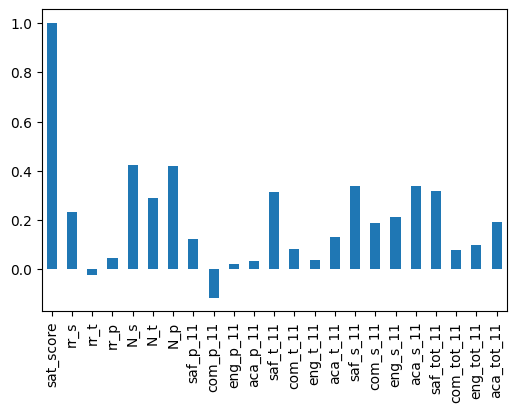

In [15]:
%matplotlib inline
survey_cor.plot.bar(x = "sat_score")

#plots correlation coeffs in relation to SAT

There are high correlations between N_s, N_t, N_p, and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense — it's difficult to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

### Safety Correlation Analysis

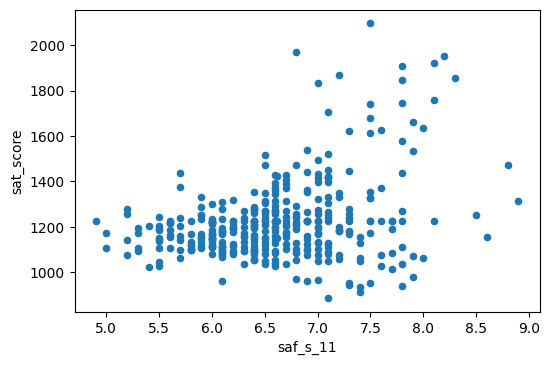

In [38]:
combined.plot.scatter("saf_s_11", "sat_score")

#safety vs SAT score scatter plot

There appears to be a correlation between SAT scores and safety, although it isn't very strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

### Boro Analysis

In [18]:
district_mean = combined.groupby("boro").agg(numpy.mean)

# calculates a mean SAT score by boro

In [37]:
district_mean["sat_score"]

boro
Bronx            1157.598203
Brooklyn         1181.364461
Manhattan        1278.331410
Queens           1286.753032
Staten Island    1382.500000
Name: sat_score, dtype: float64

Staten Island hd the highest average score with Brooklyn being the lowest

### Race Analysis

In [20]:
race = ["white_per", "asian_per", "black_per", "hispanic_per", "sat_score"]

In [21]:
race_df = combined[race]
race_df.head()

#filters on race related data and SAT scores

,white_per,asian_per,black_per,hispanic_per,sat_score
0,1.7,14.0,29.1,53.8,1122.0
1,2.3,29.2,22.6,45.9,1172.0
2,10.4,9.7,23.9,55.4,1149.0
3,1.6,9.3,31.6,56.9,1207.0
4,44.9,27.8,11.7,14.2,1621.0


In [22]:
race_corr = race_df.corr()
race_corr = race_corr["sat_score"]

#creates corrleation coeffs bewteen SAT scores and race

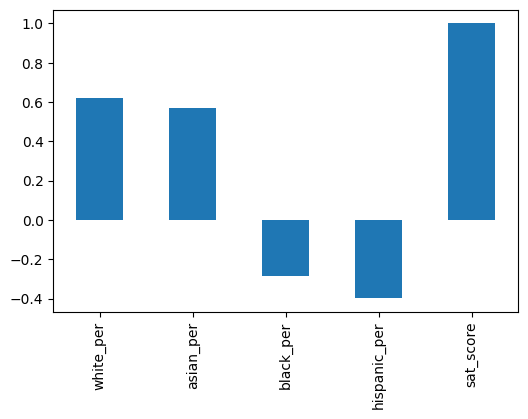

In [23]:
race_corr.plot.bar(x = "sat_score")

#plots the correlation coeffs mentioned above

It looks like a higher percentage of white or Asian students at a school correlates positively with SAT scores, whereas a higher percentage of black or Hispanic students correlates negatively with SAT score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or Hispanic students.

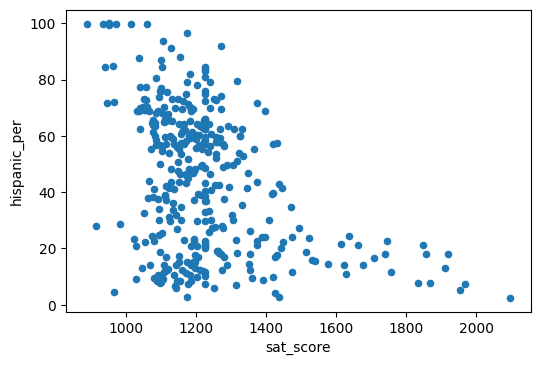

In [24]:
race_df.plot.scatter(x = "sat_score", y = "hispanic_per")

#plots SAT scores and hispanic percentages

In [25]:
hisp_odd = race_df[(race_df["sat_score"] < 1300) & (race_df["hispanic_per"] < 20)]

#filters on outlier hispanic scores with mid to low scores and low hispanic percentages

In [26]:
hisp_odd.describe()

,white_per,asian_per,black_per,hispanic_per,sat_score
count,55.000000,55.000000,55.000000,55.000000,55.000000
mean,2.807273,5.856364,78.616364,11.889091,1159.369389
std,8.164373,11.012060,17.084092,3.992339,69.050515
min,0.000000,0.000000,14.800000,2.900000,963.000000
25%,0.700000,0.900000,79.150000,8.650000,1107.000000
50%,1.300000,1.900000,83.900000,11.900000,1153.000000
75%,1.700000,4.700000,87.700000,14.650000,1204.000000
max,60.000000,62.700000,94.200000,19.100000,1287.000000


Descriptive statiscs show the low hispanic scores and low percentages have a high black percentage population.

In [28]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above appear to primarily serve recent immigrants to the U.S. These schools have many students who are learning English, which would explain the lower SAT scores.

In [29]:
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of the schools above appear to be specialized science and technology schools that receive extra funding and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT — they are students from all over New York City who did well on a standardized test.

### Gender Analysis

In [30]:
gender = ["male_per", "female_per"]

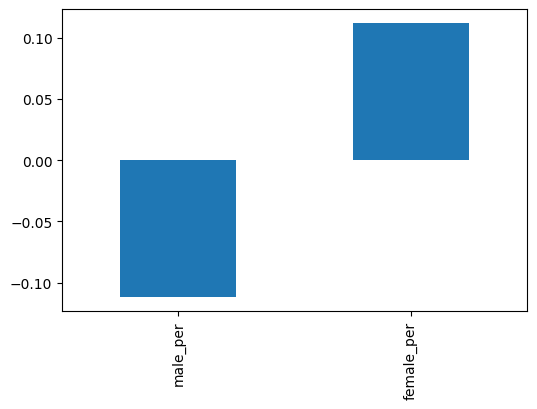

In [31]:
combined.corr()["sat_score"][gender].plot.bar()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT scores, whereas a high percentage of males at a school negatively correlates with SAT scores. Neither correlation is extremely strong.

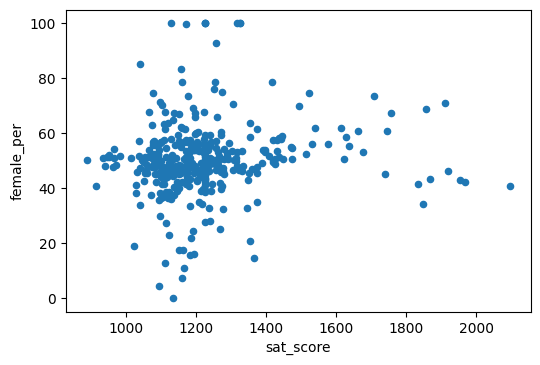

In [32]:
combined.plot.scatter(x = "sat_score", y = "female_per")

Based on the scatter plot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80) and high SAT scores.

In [33]:
combined[combined["female_per"] > 95]["SCHOOL NAME"]

15     URBAN ASSEMBLY SCHOOL OF BUSINESS FOR YOUNG WO...
70                       YOUNG WOMEN'S LEADERSHIP SCHOOL
71                       YOUNG WOMEN'S LEADERSHIP SCHOOL
104                        WOMEN'S ACADEMY OF EXCELLENCE
191    URBAN ASSEMBLY INSTITUTE OF MATH AND SCIENCE F...
264       THE URBAN ASSEMBLY SCHOOL FOR CRIMINAL JUSTICE
329              YOUNG WOMEN'S LEADERSHIP SCHOOL, QUEENS
338             YOUNG WOMEN'S LEADERSHIP SCHOOL, ASTORIA
Name: SCHOOL NAME, dtype: object

In [34]:
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appear to be very selective liberal arts schools that have high academic standards.

In [35]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

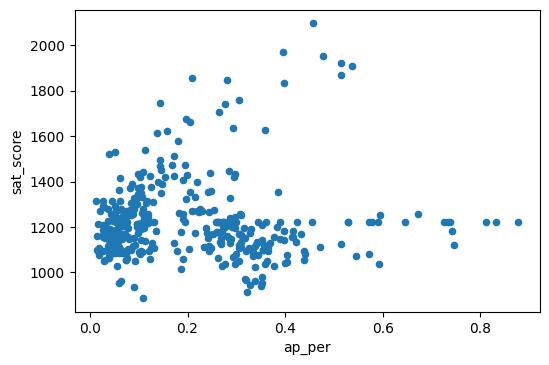

In [36]:
combined.plot.scatter(x = "ap_per", y = "sat_score")

It looks like there is a relationship between the percentage of students in a school who take the AP exam and their average SAT scores. It's not a very strong correlation, however.